# Dealing with multiple feeds


In some cases the fed-batch process uses multiple feeding mediums. This is typically the case in cultivation of mammalians cells. This tutorial will show how to use the pseudo batch transformation to handle multiple feeding mediums and how calculate rates and yields from measurements. We will, again, use simulated data to showcase the workflow. This fed-batch process seeks to mimic a cultivation of mammalians cells. These simulated cells require two substrates to grow; glucose and glutamate. The bioreactor is fed with two different feed mediums, one containing concentrated glucose and one complex medium that contain glucose, and glutamate. The feeding is also not done through a "continuous" exponential feed, but instead as pulse feed, i.e. at certain time points a given volume of each feed is added to the bioreactor.

In the simulation the cells are fed once every 24 hours and further a sample is withdrawn ever 12 hours.

## loading fedbatch data

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
import dotenv

os.chdir(dotenv.find_dotenv().replace(".env", ""))
from src.data_correction import pseudo_batch_transform_pandas, pseudo_batch_transform
from pseudobatch.datasets import load_cho_cell_like_fedbatch

In [3]:
fedbatch_df = load_cho_cell_like_fedbatch()

To use multiple feeding mediums simply add an extra column for each extra feed. NB remember that the feeding columns has to contain accumulated feed, this still applies when the culture is fed in pulses. Here is an extract of how the data is structured.

In [4]:
(fedbatch_df
    .query('(timestamp > 23.7) & (timestamp < 24.2)')
    .filter(['sample_volume', 'timestamp', 'c_Biomass', 'c_Glucose', 'c_Product', 'v_Volume', 'v_Feed_accum1', 'v_Feed_accum2'])
)

,sample_volume,timestamp,c_Biomass,c_Glucose,c_Product,v_Volume,v_Feed_accum1,v_Feed_accum2
299,0.0,23.703704,7.814135,36.468851,6.008637,700.0,0.0,0.0
300,0.0,23.783784,7.881309,36.344578,6.063821,700.0,0.0,0.0
301,0.0,23.863864,7.948997,36.219356,6.119427,700.0,0.0,0.0
302,0.0,23.943944,8.017202,36.093177,6.175458,700.0,0.0,0.0
303,0.0,24.000000,8.065254,36.004281,6.214933,700.0,0.0,0.0
304,0.0,24.024024,7.032219,43.695363,5.419862,805.0,100.0,5.0
305,0.0,24.104104,7.095742,43.577847,5.472046,805.0,100.0,5.0
306,0.0,24.184184,7.159788,43.459361,5.524661,805.0,100.0,5.0


Similar to the other examples it easier to compare before and after the transformation based on accumulated consumed substrate. This becomes a bit more complicated to calculate because we now need to handle both feeding mediums.

In [5]:
from typing import Iterable, Union
def consumed_substrate(
    concentration_in_feed: Union[float, Iterable[float]], 
    accumulated_feed_volume: Union[pd.Series, pd.DataFrame], 
    measured_substrate_mass: pd.Series, 
    initial_substrate_mass: float
)-> pd.Series:
    if len(accumulated_feed_volume.shape) == 1:
        return initial_substrate_mass + accumulated_feed_volume * concentration_in_feed - measured_substrate_mass

    # Handles the case where multiple feeds are given.
    added_substrate = np.zeros(accumulated_feed_volume.shape[0])    
    for idx, colname in enumerate(accumulated_feed_volume):
        added_substrate += accumulated_feed_volume[colname] * concentration_in_feed[idx]
    return initial_substrate_mass + added_substrate - measured_substrate_mass


Both for calculating the consumed susbtrates and to do the pseudo batch transform, we need the substrate concentration in each feeding medium. In this data this information is stored in the dataframe.

In [6]:

glucose_in_feed1 = fedbatch_df.c_Glucose_feed1.iloc[0] # 
glucose_in_feed2 = 0  # 
glutamate_in_feed1 = fedbatch_df.c_Glutamate_feed1.iloc[0] #
glutamate_in_feed2 = fedbatch_df.c_Glutamate_feed2.iloc[0] #


In [7]:
# Here the we true initial substrate mass, which is usually unknown.
# But this is only used to improve the visualisation of the data and 
# is not actaully required for the data correction.
initial_glucose_mass = fedbatch_df.m_Glucose.iloc[0]
initial_glutamate_mass = fedbatch_df.m_Glutamate.iloc[0]

fedbatch_df['m_Glucose_consumed'] = consumed_substrate(
    concentration_in_feed=glucose_in_feed1,
    accumulated_feed_volume=fedbatch_df['v_Feed_accum1'],
    measured_substrate_mass=fedbatch_df['m_Glucose'],
    initial_substrate_mass=initial_glucose_mass
)

fedbatch_df['m_Glutamate_consumed'] = consumed_substrate(
    concentration_in_feed=[glutamate_in_feed1, glutamate_in_feed2],
    accumulated_feed_volume=fedbatch_df[['v_Feed_accum1', 'v_Feed_accum2']],
    measured_substrate_mass=fedbatch_df['m_Glutamate'],
    initial_substrate_mass=initial_glutamate_mass
)

To make a more realistic example, we will assume that we only have measurements at the sampling time points. Therefore we create a dataframe which contains these measurement data only.

In [8]:
fedbatch_df_measurement = fedbatch_df.query("sample_volume > 0").copy().reset_index(drop=True)

### Overview of the simulation
First let's have a look at the simulated data. The first 8 columns stores the parameters used for the simulation. Then comes the simulated data. Columns starting with m_, c_, and v_ describes mass', concentrations and volumes, respectively.

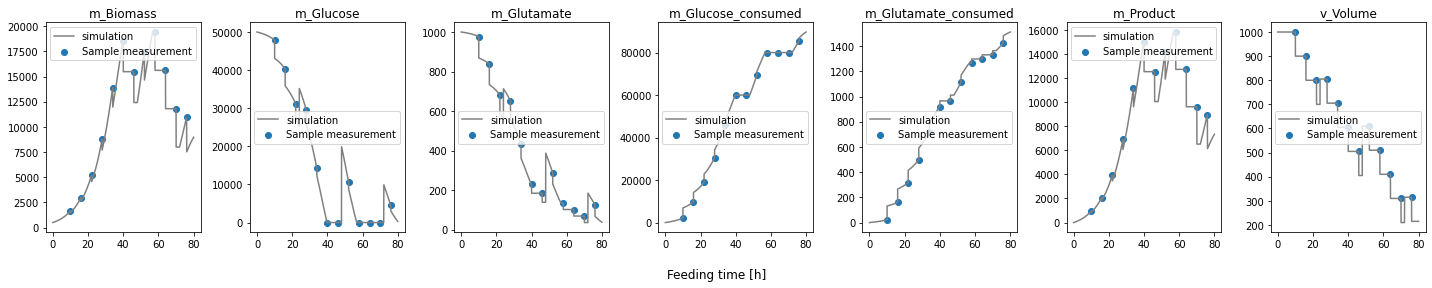

In [9]:
plot_columns = ["m_Biomass", "m_Glucose", "m_Glutamate", "m_Glucose_consumed", "m_Glutamate_consumed", "m_Product", "v_Volume"]

fig, axes = plt.subplots(nrows = 1, ncols = len(plot_columns), figsize=(20, 4))
for ax, column in zip(axes.ravel(), plot_columns):
    ax.plot(fedbatch_df["timestamp"], fedbatch_df[column], label="simulation", color="grey")
    ax.scatter(fedbatch_df_measurement["timestamp"], fedbatch_df_measurement[column], label="Sample measurement")
    ax.title.set_text(column)
    ax.legend()
fig.supxlabel("Feeding time [h]")
fig.tight_layout()

## Applying the pseudo batch transformation
We can now apply the pseudo batch transformation to the data. Notice that to include both feeds we simply supply a list of the columns names of each feed. The `concentrations_in_feed` is specified as follows: The outer list iterates over the measured concentrations (in this case Biomass, Glucose, Product, CO2, Glutamate), while the inner list iterates over the feeding mediums. **Important:** the order HAS to be the same for `concetration_in_feed` and both `measured_concentration_colnames` and `accumulated_feed_colname`!

In [10]:
fedbatch_df_measurement[["c_Biomass_pseudo", "c_Glucose_pseudo", "c_Product_pseudo", "c_CO2_pseudo", "c_Glutamate_pseudo"]] = pseudo_batch_transform_pandas(
    df=fedbatch_df_measurement,
    measured_concentration_colnames=['c_Biomass', 'c_Glucose', 'c_Product', 'c_CO2', 'c_Glutamate'],
    reactor_volume_colname='v_Volume',
    accumulated_feed_colname=['v_Feed_accum1', 'v_Feed_accum2'],
    concentration_in_feed=[[0, 0], [glucose_in_feed1, glucose_in_feed2], [0, 0], [0, 0], [glutamate_in_feed1, glutamate_in_feed2]],
    sample_volume_colname='sample_volume'
)

We can now calculate the consumed pseudo concentrations.

In [11]:
fedbatch_df_measurement['c_Glucose_consumed_pseudo'] = initial_glucose_mass/fedbatch_df.v_Volume.iloc[0] - fedbatch_df_measurement['c_Glucose_pseudo']
fedbatch_df_measurement['c_Glutamate_consumed_pseudo'] = initial_glutamate_mass / fedbatch_df.v_Volume.iloc[0] - fedbatch_df_measurement['c_Glutamate_pseudo']

To make better visualizations we calculate the pseudo mass'.

In [12]:
fedbatch_df_measurement[["m_Biomass_pseudo", "m_Glucose_consumed_pseudo", "m_Glutamate_consumed_pseudo", "m_Product_pseudo", "m_CO2_pseudo"]] = fedbatch_df_measurement[["c_Biomass_pseudo", "c_Glucose_consumed_pseudo", "c_Glutamate_consumed_pseudo", "c_Product_pseudo", "c_CO2_pseudo"]] * fedbatch_df["v_Volume"].iloc[0]

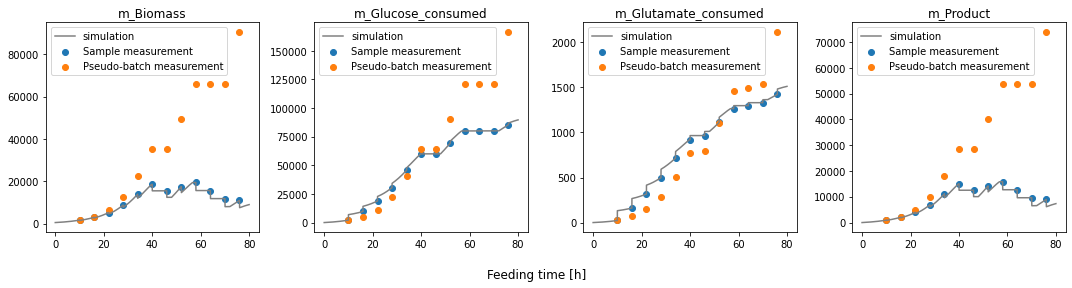

In [13]:
plot_columns = ["m_Biomass", "m_Glucose_consumed", "m_Glutamate_consumed", "m_Product"]

fig, axes = plt.subplots(nrows = 1, ncols = len(plot_columns), figsize=(15, 4))
for ax, column in zip(axes.ravel(), plot_columns):
    ax.plot(fedbatch_df["timestamp"], fedbatch_df[column], label="simulation", color="grey")
    ax.scatter(fedbatch_df_measurement["timestamp"], fedbatch_df_measurement[column], label="Sample measurement")
    ax.scatter(fedbatch_df_measurement["timestamp"], fedbatch_df_measurement[column + '_pseudo'], label="Pseudo-batch measurement")
    ax.title.set_text(column)
    ax.legend()
fig.supxlabel("Feeding time [h]")
fig.tight_layout()

## Estimate the rates

We can estimate the through the finite difference method or other derivative estimation methods (See Estimate time series parameters tutorial for more information.).

In [16]:
def finite_difference_derivative(df: pd.DataFrame, x_colname: str, y_colname: str)->np.ndarray:
    x = df[x_colname].to_numpy()
    y = df[y_colname].to_numpy()
    return np.gradient(y, x)


mu_hat = finite_difference_derivative(fedbatch_df_measurement, "timestamp", "c_Biomass_pseudo") / fedbatch_df_measurement.c_Biomass_pseudo

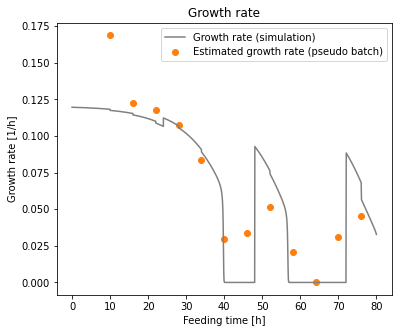

In [17]:
growth_rate_fig, growth_rate_ax = plt.subplots(figsize=(6, 5))
growth_rate_ax.plot(fedbatch_df.timestamp, fedbatch_df.mu_true, label="Growth rate (simulation)", color = "grey")
growth_rate_ax.scatter(fedbatch_df_measurement.timestamp, mu_hat, label="Estimated growth rate (pseudo batch)", color = "C1")
growth_rate_ax.set_title("Growth rate")
growth_rate_ax.set_xlabel("Feeding time [h]")
growth_rate_ax.set_ylabel("Growth rate [1/h]")
growth_rate_ax.legend()